# Cats Vs Dogs
I'm going to use [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) to finetune a pre-existing model to differentiate between Cats and Dogs.

## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
import time
%matplotlib inline

In [2]:
#torch.__version__

'2.0.1'

In [3]:
#import sys
#sys.version

'3.11.4 (v3.11.4:d2340ef257, Jun  6 2023, 19:15:51) [Clang 13.0.0 (clang-1300.0.29.30)]'

**This file is intended to run on Google Colab**

Check if GPU is available, if not change the runtime

In [4]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


## Download the Data

The data from [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) consists of two files: images.tar.gz and annotations.tar.gz

In [5]:
#%pwd

'/Users/jmello/Projects/CatDog'

In [6]:
#%mkdir data
#%cd data

/Users/jmello/Projects/CatDog/data


In [1]:
#!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
#!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2023-06-27 14:20:01--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-06-27 14:20:01--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-06-27 14:20:02--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

Extract the downloaded files

In [2]:
#!tar zxvf images.tar.gz
#!tar zxvf annotations.tar.gz

x images/
x images/boxer_16.jpg
x images/chihuahua_165.jpg
x images/pug_183.jpg
x images/english_setter_1.jpg
x images/chihuahua_170.jpg
x images/english_cocker_spaniel_17.jpg
x images/samoyed_39.jpg
x images/Egyptian_Mau_62.jpg
x images/samoyed_36.jpg
x images/german_shorthaired_3.jpg
x images/Ragdoll_183.jpg
x images/British_Shorthair_64.jpg
x images/american_pit_bull_terrier_57.jpg
x images/beagle_120.jpg
x images/american_bulldog_174.jpg
x images/chihuahua_101.jpg
x images/shiba_inu_136.jpg
x images/Abyssinian_136.jpg
x images/Siamese_201.jpg
x images/Abyssinian_85.jpg
x images/saint_bernard_145.jpg
x images/Siamese_63.jpg
x images/leonberger_164.jpg
x images/Maine_Coon_126.jpg
x images/samoyed_51.jpg
x images/Birman_15.jpg
x images/english_cocker_spaniel_181.jpg
x images/english_cocker_spaniel_128.jpg
x images/leonberger_133.jpg
x images/english_cocker_spaniel_6.jpg
x images/miniature_pinscher_119.jpg
x images/american_pit_bull_terrier_27.jpg
x images/Abyssinian_37.jpg
x images/Bo

x images/basset_hound_37.jpg
x images/pomeranian_71.jpg
x images/Bombay_208.jpg
x images/samoyed_187.jpg
x images/staffordshire_bull_terrier_123.jpg
x images/Ragdoll_7.jpg
x images/english_setter_26.jpg
x images/english_cocker_spaniel_177.jpg
x images/american_bulldog_217.jpg
x images/Sphynx_53.jpg
x images/pug_88.jpg
x images/shiba_inu_212.jpg
x images/havanese_71.jpg
x images/chihuahua_38.jpg
x images/basset_hound_67.jpg
x images/wheaten_terrier_18.jpg
x images/keeshond_8.jpg
x images/great_pyrenees_48.jpg
x images/chihuahua_180.jpg
x images/shiba_inu_161.jpg
x images/keeshond_88.jpg
x images/beagle_186.jpg
x images/german_shorthaired_7.jpg
x images/Ragdoll_170.jpg
x images/samoyed_168.jpg
x images/miniature_pinscher_106.jpg
x images/beagle_97.jpg
x images/boxer_156.jpg
x images/leonberger_67.jpg
x images/Egyptian_Mau_224.jpg
x images/Birman_151.jpg
x images/boxer_64.jpg
x images/american_bulldog_25.jpg
x images/english_cocker_spaniel_165.jpg
x images/Abyssinian_9.jpg
x images/scotti

x images/Ragdoll_184.jpg
x images/great_pyrenees_106.jpg
x images/Ragdoll_92.jpg
x images/leonberger_144.jpg
x images/Bengal_148.jpg
x images/scottish_terrier_13.jpg
x images/german_shorthaired_124.jpg
x images/British_Shorthair_276.jpg
x images/Maine_Coon_269.jpg
x images/Ragdoll_112.jpg
x images/samoyed_40.jpg
x images/samoyed_77.jpg
x images/japanese_chin_22.jpg
x images/havanese_152.jpg
x images/samoyed_105.jpg
x images/Siamese_182.jpg
x images/keeshond_177.jpg
x images/great_pyrenees_145.jpg
x images/yorkshire_terrier_176.jpg
x images/basset_hound_14.jpg
x images/pug_63.jpg
x images/Persian_156.jpg
x images/Bengal_75.jpg
x images/Ragdoll_164.jpg
x images/scottish_terrier_98.jpg
x images/beagle_22.jpg
x images/english_cocker_spaniel_142.jpg
x images/Maine_Coon_242.jpg
x images/keeshond_144.jpg
x images/great_pyrenees_179.jpg
x images/scottish_terrier_123.jpg
x images/British_Shorthair_86.jpg
x images/Abyssinian_51.jpg
x images/shiba_inu_16.jpg
x images/samoyed_2.jpg
x images/german

x images/saint_bernard_94.jpg
x images/staffordshire_bull_terrier_6.jpg
x images/Persian_160.jpg
x images/pomeranian_192.jpg
x images/leonberger_182.jpg
x images/Abyssinian_45.jpg
x images/great_pyrenees_107.jpg
x images/english_cocker_spaniel_67.jpg
x images/shiba_inu_182.jpg
x images/Egyptian_Mau_167.jpg
x images/english_setter_127.jpg
x images/miniature_pinscher_43.jpg
x images/american_pit_bull_terrier_151.jpg
x images/american_bulldog_23.jpg
x images/Siamese_40.jpg
x images/shiba_inu_71.jpg
x images/english_setter_145.jpg
x images/Egyptian_Mau_109.jpg
x images/yorkshire_terrier_183.jpg
x images/Abyssinian_14.jpg
x images/Bombay_55.jpg
x images/shiba_inu_81.jpg
x images/staffordshire_bull_terrier_21.jpg
x images/wheaten_terrier_190.jpg
x images/chihuahua_99.jpg
x images/great_pyrenees_126.jpg
x images/Ragdoll_56.jpg
x images/yorkshire_terrier_27.jpg
x images/pug_199.jpg
x images/great_pyrenees_185.jpg
x images/shiba_inu_120.jpg
x images/pug_140.jpg
x images/newfoundland_72.jpg
x im

x images/newfoundland_80.jpg
x images/chihuahua_175.jpg
x images/japanese_chin_119.jpg
x images/Persian_169.jpg
x images/Persian_41.jpg
x images/samoyed_72.jpg
x images/Russian_Blue_220.jpg
x images/Maine_Coon_201.jpg
x images/japanese_chin_11.jpg
x images/german_shorthaired_8.jpg
x images/havanese_162.jpg
x images/english_cocker_spaniel_141.jpg
x images/Bombay_204.jpg
x images/Bombay_137.jpg
x images/boxer_48.jpg
x images/British_Shorthair_40.jpg
x images/miniature_pinscher_40.jpg
x images/scottish_terrier_57.jpg
x images/american_pit_bull_terrier_42.jpg
x images/Russian_Blue_162.jpg
x images/newfoundland_132.jpg
x images/leonberger_11.jpg
x images/basset_hound_181.jpg
x images/english_setter_131.jpg
x images/yorkshire_terrier_73.jpg
x images/newfoundland_33.jpg
x images/staffordshire_bull_terrier_33.jpg
x images/samoyed_199.jpg
x images/Bengal_199.jpg
x images/Bengal_160.jpg
x images/Siamese_59.jpg
x images/Birman_181.jpg
x images/scottish_terrier_173.jpg
x images/staffordshire_bull_

x images/wheaten_terrier_181.jpg
x images/Maine_Coon_135.jpg
x images/Maine_Coon_155.jpg
x images/american_pit_bull_terrier_90.jpg
x images/Ragdoll_169.jpg
x images/staffordshire_bull_terrier_184.jpg
x images/keeshond_6.jpg
x images/yorkshire_terrier_67.jpg
x images/Russian_Blue_112.jpg
x images/pomeranian_149.jpg
x images/havanese_67.jpg
x images/chihuahua_163.jpg
x images/great_pyrenees_58.jpg
x images/Persian_94.jpg
x images/Egyptian_Mau_147.jpg
x images/Sphynx_94.jpg
x images/german_shorthaired_10.jpg
x images/boxer_110.jpg
x images/american_pit_bull_terrier_87.jpg
x images/shiba_inu_80.jpg
x images/newfoundland_172.jpg
x images/pug_30.jpg
x images/american_bulldog_198.jpg
x images/basset_hound_38.jpg
x images/miniature_pinscher_178.jpg
x images/Birman_161.jpg
x images/pug_145.jpg
x images/Bengal_179.jpg
x images/leonberger_52.jpg
x images/staffordshire_bull_terrier_137.jpg
x images/Egyptian_Mau_68.jpg
x images/samoyed_71.jpg
x images/havanese_144.jpg
x images/yorkshire_terrier_96.

x images/staffordshire_bull_terrier_176.jpg
x images/keeshond_99.jpg
x images/Ragdoll_113.jpg
x images/american_pit_bull_terrier_11.jpg
x images/leonberger_199.jpg
x images/english_cocker_spaniel_195.jpg
x images/american_bulldog_218.jpg
x images/japanese_chin_189.jpg
x images/beagle_33.jpg
x images/havanese_18.jpg
x images/British_Shorthair_174.jpg
x images/english_setter_143.jpg
x images/Egyptian_Mau_127.jpg
x images/havanese_131.jpg
x images/leonberger_101.jpg
x images/japanese_chin_72.jpg
x images/pomeranian_117.jpg
x images/Sphynx_84.jpg
x images/basset_hound_61.jpg
x images/miniature_pinscher_181.jpg
x images/english_cocker_spaniel_22.jpg
x images/Egyptian_Mau_215.jpg
x images/basset_hound_180.jpg
x images/american_pit_bull_terrier_74.jpg
x images/Maine_Coon_195.jpg
x images/Bengal_183.jpg
x images/Siamese_74.jpg
x images/american_bulldog_194.jpg
x images/Birman_175.jpg
x images/american_bulldog_178.jpg
x images/staffordshire_bull_terrier_93.jpg
x images/Egyptian_Mau_58.jpg
x ima

x images/pug_130.jpg
x images/shiba_inu_77.jpg
x images/British_Shorthair_68.jpg
x images/newfoundland_85.jpg
x images/newfoundland_171.jpg
x images/german_shorthaired_117.jpg
x images/Siamese_52.jpg
x images/staffordshire_bull_terrier_11.jpg
x images/scottish_terrier_28.jpg
x images/english_setter_188.jpg
x images/beagle_71.jpg
x images/english_cocker_spaniel_12.jpg
x images/great_pyrenees_17.jpg
x images/Russian_Blue_99.jpg
x images/saint_bernard_64.jpg
x images/Bengal_150.jpg
x images/British_Shorthair_59.jpg
x images/basset_hound_197.jpg
x images/great_pyrenees_43.jpg
x images/american_bulldog_66.jpg
x images/Maine_Coon_8.jpg
x images/great_pyrenees_177.jpg
x images/Maine_Coon_208.jpg
x images/pomeranian_107.jpg
x images/Siamese_162.jpg
x images/saint_bernard_146.jpg
x images/Ragdoll_149.jpg
x images/english_cocker_spaniel_188.jpg
x images/german_shorthaired_163.jpg
x images/basset_hound_99.jpg
x images/american_pit_bull_terrier_71.jpg
x images/english_setter_67.jpg
x images/englis

x images/beagle_112.jpg
x images/great_pyrenees_4.jpg
x images/english_cocker_spaniel_103.jpg
x images/Abyssinian_157.jpg
x images/Persian_65.jpg
x images/english_setter_162.jpg
x images/Maine_Coon_170.jpg
x images/samoyed_198.jpg
x images/Egyptian_Mau_98.jpg
x images/samoyed_94.jpg
x images/British_Shorthair_113.jpg
x images/Russian_Blue_69.jpg
x images/american_bulldog_53.jpg
x images/american_bulldog_94.jpg
x images/havanese_153.jpg
x images/Persian_17.jpg
x images/Siamese_86.jpg
x images/Sphynx_139.jpg
x images/British_Shorthair_177.jpg
x images/Russian_Blue_142.jpg
x images/Birman_112.jpg
x images/yorkshire_terrier_30.jpg
x images/basset_hound_152.jpg
x images/english_cocker_spaniel_87.jpg
x images/pomeranian_33.jpg
x images/miniature_pinscher_197.jpg
x images/Bombay_178.jpg
x images/english_cocker_spaniel_41.jpg
x images/great_pyrenees_144.jpg
x images/Siamese_27.jpg
x images/Sphynx_112.jpg
x images/miniature_pinscher_185.jpg
x images/english_cocker_spaniel_148.jpg
x images/engli

x images/english_setter_96.jpg
x images/shiba_inu_79.jpg
x images/Egyptian_Mau_39.jpg
x images/great_pyrenees_139.jpg
x images/Birman_61.jpg
x images/miniature_pinscher_51.jpg
x images/beagle_9.jpg
x images/Birman_108.jpg
x images/Abyssinian_133.jpg
x images/Sphynx_41.jpg
x images/beagle_127.jpg
x images/Maine_Coon_5.jpg
x images/Bombay_119.jpg
x images/shiba_inu_93.jpg
x images/english_setter_157.jpg
x images/Bombay_114.jpg
x images/British_Shorthair_126.jpg
x images/american_pit_bull_terrier_16.jpg
x images/american_bulldog_201.jpg
x images/german_shorthaired_26.jpg
x images/beagle_151.jpg
x images/american_pit_bull_terrier_165.jpg
x images/British_Shorthair_182.jpg
x images/Persian_200.jpg
x images/boxer_19.jpg
x images/Bombay_139.jpg
x images/keeshond_116.jpg
x images/Birman_5.jpg
x images/Bengal_194.jpg
x images/Persian_70.jpg
x images/Maine_Coon_175.jpg
x images/american_bulldog_123.jpg
x images/Bombay_87.jpg
x images/german_shorthaired_59.jpg
x images/english_setter_136.jpg
x im

x images/Egyptian_Mau_76.jpg
x images/newfoundland_62.jpg
x images/British_Shorthair_118.jpg
x images/yorkshire_terrier_190.jpg
x images/pug_68.jpg
x images/yorkshire_terrier_43.jpg
x images/american_bulldog_20.jpg
x images/Russian_Blue_205.jpg
x images/pomeranian_88.jpg
x images/Birman_162.jpg
x images/Russian_Blue_253.jpg
x images/japanese_chin_149.jpg
x images/german_shorthaired_35.jpg
x images/yorkshire_terrier_87.jpg
x images/leonberger_108.jpg
x images/pug_117.jpg
x images/chihuahua_109.jpg
x images/Persian_60.jpg
x images/leonberger_138.jpg
x images/Persian_58.jpg
x images/american_pit_bull_terrier_132.jpg
x images/Abyssinian_40.jpg
x images/Siamese_93.jpg
x images/boxer_65.jpg
x images/saint_bernard_96.jpg
x images/german_shorthaired_101.jpg
x images/basset_hound_111.jpg
x images/scottish_terrier_51.jpg
x images/american_bulldog_101.jpg
x images/Bengal_189.jpg
x images/staffordshire_bull_terrier_16.jpg
x images/german_shorthaired_5.jpg
x images/Russian_Blue_102.jpg
x images/sai

x images/Egyptian_Mau_146.jpg
x images/staffordshire_bull_terrier_121.jpg
x images/miniature_pinscher_144.jpg
x images/leonberger_76.jpg
x images/Bombay_125.jpg
x images/basset_hound_139.jpg
x images/japanese_chin_153.jpg
x images/scottish_terrier_1.jpg
x images/great_pyrenees_86.jpg
x images/pug_109.jpg
x images/samoyed_84.jpg
x images/Bombay_151.jpg
x images/Maine_Coon_189.jpg
x images/saint_bernard_55.jpg
x images/havanese_69.jpg
x images/saint_bernard_198.jpg
x images/wheaten_terrier_133.jpg
x images/saint_bernard_135.jpg
x images/Persian_270.jpg
x images/german_shorthaired_156.jpg
x images/scottish_terrier_35.jpg
x images/basset_hound_36.jpg
x images/pomeranian_169.jpg
x images/Birman_9.jpg
x images/samoyed_120.jpg
x images/saint_bernard_76.jpg
x images/boxer_195.jpg
x images/english_cocker_spaniel_155.jpg
x images/newfoundland_119.jpg
x images/english_cocker_spaniel_114.jpg
x images/Persian_135.jpg
x images/Sphynx_4.jpg
x images/Abyssinian_75.jpg
x images/wheaten_terrier_153.jpg


x images/Siamese_234.jpg
x images/British_Shorthair_79.jpg
x images/wheaten_terrier_25.jpg
x images/British_Shorthair_162.jpg
x images/beagle_66.jpg
x images/scottish_terrier_2.jpg
x images/scottish_terrier_64.jpg
x images/Russian_Blue_180.jpg
x images/japanese_chin_19.jpg
x images/chihuahua_115.jpg
x images/chihuahua_91.jpg
x images/Abyssinian_116.jpg
x images/boxer_55.jpg
x images/english_setter_45.jpg
x images/saint_bernard_143.jpg
x images/great_pyrenees_66.jpg
x images/japanese_chin_6.jpg
x images/Sphynx_132.jpg
x images/Maine_Coon_39.jpg
x images/newfoundland_185.jpg
x images/Sphynx_45.jpg
x images/scottish_terrier_14.jpg
x images/Russian_Blue_111.jpg
x images/beagle_197.jpg
x images/beagle_185.jpg
x images/newfoundland_64.jpg
x images/British_Shorthair_77.jpg
x images/Sphynx_213.jpg
x images/Russian_Blue_200.jpg
x images/keeshond_56.jpg
x images/miniature_pinscher_112.jpg
x images/British_Shorthair_91.jpg
x images/Sphynx_158.jpg
x images/Persian_2.jpg
x images/Abyssinian_19.jpg


x images/newfoundland_69.jpg
x images/keeshond_48.jpg
x images/samoyed_48.jpg
x images/miniature_pinscher_45.jpg
x images/scottish_terrier_196.jpg
x images/wheaten_terrier_149.jpg
x images/leonberger_163.jpg
x images/Egyptian_Mau_120.jpg
x images/Sphynx_131.jpg
x images/american_pit_bull_terrier_154.jpg
x images/american_pit_bull_terrier_194.jpg
x images/Russian_Blue_88.jpg
x images/english_setter_94.jpg
x images/pomeranian_185.jpg
x images/Persian_68.jpg
x images/keeshond_106.jpg
x images/Sphynx_151.jpg
x images/Ragdoll_162.jpg
x images/english_cocker_spaniel_137.jpg
x images/Ragdoll_105.jpg
x images/samoyed_60.jpg
x images/keeshond_5.jpg
x images/boxer_174.jpg
x images/basset_hound_147.jpg
x images/Ragdoll_262.jpg
x images/leonberger_23.jpg
x images/Egyptian_Mau_95.jpg
x images/staffordshire_bull_terrier_14.jpg
x images/Abyssinian_193.jpg
x images/pug_141.jpg
x images/chihuahua_131.jpg
x images/Bombay_101.jpg
x images/chihuahua_85.jpg
x images/great_pyrenees_96.jpg
x images/yorkshire

x images/Bombay_97.jpg
x images/boxer_77.jpg
x images/Maine_Coon_19.jpg
x images/Maine_Coon_133.jpg
x images/american_pit_bull_terrier_13.jpg
x images/Persian_108.jpg
x images/Siamese_167.jpg
x images/scottish_terrier_100.jpg
x images/wheaten_terrier_42.jpg
x images/staffordshire_bull_terrier_160.jpg
x images/yorkshire_terrier_171.jpg
x images/german_shorthaired_77.jpg
x images/Egyptian_Mau_214.jpg
x images/Siamese_176.jpg
x images/havanese_147.jpg
x images/basset_hound_86.jpg
x images/basset_hound_92.jpg
x images/samoyed_158.jpg
x images/great_pyrenees_80.jpg
x images/Siamese_194.jpg
x images/Maine_Coon_213.jpg
x images/japanese_chin_16.jpg
x images/Bombay_126.jpg
x images/pomeranian_118.jpg
x images/Maine_Coon_94.jpg
x images/beagle_10.jpg
x images/saint_bernard_119.jpg
x images/Birman_86.jpg
x images/Siamese_28.jpg
x images/english_setter_107.jpg
x images/shiba_inu_194.jpg
x images/Russian_Blue_87.jpg
x images/newfoundland_123.jpg
x images/basset_hound_39.jpg
x images/english_cocker

x images/Persian_272.jpg
x images/japanese_chin_59.jpg
x images/Russian_Blue_198.jpg
x images/Bombay_111.jpg
x images/Maine_Coon_246.jpg
x images/scottish_terrier_12.jpg
x images/keeshond_82.jpg
x images/Persian_34.jpg
x images/yorkshire_terrier_69.jpg
x images/Egyptian_Mau_50.jpg
x images/boxer_15.jpg
x images/english_cocker_spaniel_182.jpg
x images/yorkshire_terrier_144.jpg
x images/wheaten_terrier_177.jpg
x images/pomeranian_57.jpg
x images/Russian_Blue_209.jpg
x images/keeshond_159.jpg
x images/basset_hound_81.jpg
x images/boxer_60.jpg
x images/Birman_176.jpg
x images/shiba_inu_75.jpg
x images/scottish_terrier_155.jpg
x images/yorkshire_terrier_162.jpg
x images/american_bulldog_199.jpg
x images/saint_bernard_51.jpg
x images/Russian_Blue_103.jpg
x images/havanese_43.jpg
x images/basset_hound_162.jpg
x images/Russian_Blue_172.jpg
x images/pug_134.jpg
x images/Persian_118.jpg
x images/basset_hound_158.jpg
x images/wheaten_terrier_194.jpg
x images/wheaten_terrier_160.jpg
x images/Benga

x images/german_shorthaired_128.jpg
x images/Bombay_13.jpg
x images/shiba_inu_106.jpg
x images/leonberger_83.jpg
x images/samoyed_173.jpg
x images/german_shorthaired_98.jpg
x images/shiba_inu_127.jpg
x images/British_Shorthair_223.jpg
x images/Abyssinian_177.jpg
x images/samoyed_93.jpg
x images/havanese_160.jpg
x images/yorkshire_terrier_166.jpg
x images/yorkshire_terrier_189.jpg
x images/Maine_Coon_128.jpg
x images/english_cocker_spaniel_125.jpg
x images/Persian_143.jpg
x images/havanese_161.jpg
x images/Siamese_34.jpg
x images/Bombay_82.jpg
x images/german_shorthaired_83.jpg
x images/Abyssinian_121.jpg
x images/Russian_Blue_92.jpg
x images/Abyssinian_74.jpg
x images/german_shorthaired_176.jpg
x images/staffordshire_bull_terrier_145.jpg
x images/Maine_Coon_132.jpg
x images/Ragdoll_87.jpg
x images/leonberger_125.jpg
x images/wheaten_terrier_169.jpg
x images/yorkshire_terrier_131.jpg
x images/shiba_inu_61.jpg
x images/Siamese_198.jpg
x images/Egyptian_Mau_113.jpg
x images/chihuahua_12.j

x images/keeshond_143.jpg
x images/Siamese_233.jpg
x images/english_setter_15.jpg
x images/boxer_32.jpg
x images/german_shorthaired_141.jpg
x images/english_cocker_spaniel_8.jpg
x images/leonberger_128.jpg
x images/pomeranian_186.jpg
x images/Sphynx_169.jpg
x images/leonberger_172.jpg
x images/beagle_194.jpg
x images/japanese_chin_43.jpg
x images/english_cocker_spaniel_40.jpg
x images/havanese_102.jpg
x images/Siamese_227.jpg
x images/scottish_terrier_128.jpg
x images/basset_hound_160.jpg
x images/miniature_pinscher_30.jpg
x images/miniature_pinscher_122.jpg
x images/Siamese_189.jpg
x images/Maine_Coon_25.jpg
x images/Siamese_57.jpg
x images/havanese_79.jpg
x images/american_bulldog_10.jpg
x images/Maine_Coon_52.jpg
x images/miniature_pinscher_58.jpg
x images/japanese_chin_111.jpg
x images/beagle_164.jpg
x images/scottish_terrier_62.jpg
x images/wheaten_terrier_91.jpg
x images/beagle_63.jpg
x images/havanese_59.jpg
x images/Birman_85.jpg
x images/Persian_98.jpg
x images/american_pit_bu

x images/japanese_chin_87.jpg
x images/havanese_109.jpg
x images/staffordshire_bull_terrier_12.jpg
x images/japanese_chin_70.jpg
x images/beagle_109.jpg
x images/scottish_terrier_183.jpg
x images/english_cocker_spaniel_20.jpg
x images/newfoundland_2.jpg
x images/saint_bernard_121.jpg
x images/Bengal_105.jpg
x images/Abyssinian_206.jpg
x images/japanese_chin_41.jpg
x images/Ragdoll_171.jpg
x images/keeshond_41.jpg
x images/japanese_chin_128.jpg
x images/english_setter_78.jpg
x images/american_bulldog_109.jpg
x images/staffordshire_bull_terrier_97.jpg
x images/Birman_83.jpg
x images/shiba_inu_91.jpg
x images/miniature_pinscher_98.jpg
x images/Siamese_88.jpg
x images/english_cocker_spaniel_166.jpg
x images/Ragdoll_186.jpg
x images/Russian_Blue_222.jpg
x images/yorkshire_terrier_18.jpg
x images/pug_67.jpg
x images/havanese_191.jpg
x images/Egyptian_Mau_222.jpg
x images/shiba_inu_40.jpg
x images/Maine_Coon_9.jpg
x images/saint_bernard_62.jpg
x images/havanese_4.jpg
x images/miniature_pinsch

x images/Russian_Blue_212.jpg
x images/pug_12.jpg
x images/Egyptian_Mau_138.jpg
x images/keeshond_21.jpg
x images/boxer_128.jpg
x images/newfoundland_94.jpg
x images/american_pit_bull_terrier_142.jpg
x images/pug_82.jpg
x images/yorkshire_terrier_101.jpg
x images/beagle_184.jpg
x images/pug_148.jpg
x images/boxer_160.jpg
x images/japanese_chin_179.jpg
x images/miniature_pinscher_125.jpg
x images/great_pyrenees_180.jpg
x images/Siamese_232.jpg
x images/havanese_98.jpg
x images/samoyed_12.jpg
x images/miniature_pinscher_176.jpg
x images/havanese_187.jpg
x images/chihuahua_150.jpg
x images/scottish_terrier_69.jpg
x images/english_cocker_spaniel_69.jpg
x images/Bombay_158.jpg
x images/Bombay_157.jpg
x images/yorkshire_terrier_122.jpg
x images/samoyed_125.jpg
x images/beagle_174.jpg
x images/Birman_82.jpg
x images/keeshond_59.jpg
x images/japanese_chin_89.jpg
x images/great_pyrenees_35.jpg
x images/havanese_76.jpg
x images/japanese_chin_49.jpg
x images/english_setter_4.jpg
x images/beagle_2

x annotations/xmls/basset_hound_174.xml
x annotations/xmls/basset_hound_175.xml
x annotations/xmls/basset_hound_176.xml
x annotations/xmls/basset_hound_177.xml
x annotations/xmls/basset_hound_178.xml
x annotations/xmls/basset_hound_179.xml
x annotations/xmls/basset_hound_18.xml
x annotations/xmls/basset_hound_180.xml
x annotations/xmls/basset_hound_181.xml
x annotations/xmls/basset_hound_182.xml
x annotations/xmls/basset_hound_183.xml
x annotations/xmls/basset_hound_184.xml
x annotations/xmls/basset_hound_185.xml
x annotations/xmls/basset_hound_186.xml
x annotations/xmls/basset_hound_187.xml
x annotations/xmls/basset_hound_188.xml
x annotations/xmls/basset_hound_189.xml
x annotations/xmls/basset_hound_190.xml
x annotations/xmls/beagle_10.xml
x annotations/xmls/beagle_100.xml
x annotations/xmls/beagle_101.xml
x annotations/xmls/beagle_102.xml
x annotations/xmls/beagle_103.xml
x annotations/xmls/beagle_104.xml
x annotations/xmls/beagle_105.xml
x annotations/xmls/beagle_107.xml
x annotati

x annotations/xmls/chihuahua_180.xml
x annotations/xmls/chihuahua_181.xml
x annotations/xmls/chihuahua_182.xml
x annotations/xmls/chihuahua_183.xml
x annotations/xmls/chihuahua_184.xml
x annotations/xmls/chihuahua_185.xml
x annotations/xmls/chihuahua_186.xml
x annotations/xmls/chihuahua_187.xml
x annotations/xmls/chihuahua_188.xml
x annotations/xmls/chihuahua_189.xml
x annotations/xmls/chihuahua_190.xml
x annotations/xmls/Egyptian_Mau_10.xml
x annotations/xmls/Egyptian_Mau_100.xml
x annotations/xmls/Egyptian_Mau_101.xml
x annotations/xmls/Egyptian_Mau_102.xml
x annotations/xmls/Egyptian_Mau_103.xml
x annotations/xmls/Egyptian_Mau_104.xml
x annotations/xmls/Egyptian_Mau_105.xml
x annotations/xmls/Egyptian_Mau_106.xml
x annotations/xmls/Egyptian_Mau_107.xml
x annotations/xmls/Egyptian_Mau_108.xml
x annotations/xmls/Egyptian_Mau_109.xml
x annotations/xmls/Egyptian_Mau_11.xml
x annotations/xmls/Egyptian_Mau_110.xml
x annotations/xmls/Egyptian_Mau_111.xml
x annotations/xmls/Egyptian_Mau_112

x annotations/xmls/japanese_chin_184.xml
x annotations/xmls/japanese_chin_185.xml
x annotations/xmls/japanese_chin_186.xml
x annotations/xmls/japanese_chin_187.xml
x annotations/xmls/japanese_chin_188.xml
x annotations/xmls/japanese_chin_189.xml
x annotations/xmls/japanese_chin_190.xml
x annotations/xmls/keeshond_10.xml
x annotations/xmls/keeshond_100.xml
x annotations/xmls/keeshond_101.xml
x annotations/xmls/keeshond_102.xml
x annotations/xmls/keeshond_103.xml
x annotations/xmls/keeshond_104.xml
x annotations/xmls/keeshond_105.xml
x annotations/xmls/keeshond_106.xml
x annotations/xmls/keeshond_107.xml
x annotations/xmls/keeshond_108.xml
x annotations/xmls/keeshond_109.xml
x annotations/xmls/keeshond_11.xml
x annotations/xmls/keeshond_110.xml
x annotations/xmls/keeshond_111.xml
x annotations/xmls/keeshond_112.xml
x annotations/xmls/keeshond_113.xml
x annotations/xmls/keeshond_114.xml
x annotations/xmls/keeshond_115.xml
x annotations/xmls/keeshond_116.xml
x annotations/xmls/keeshond_117

x annotations/xmls/pug_117.xml
x annotations/xmls/pug_118.xml
x annotations/xmls/pug_119.xml
x annotations/xmls/pug_12.xml
x annotations/xmls/pug_120.xml
x annotations/xmls/pug_121.xml
x annotations/xmls/pug_122.xml
x annotations/xmls/pug_123.xml
x annotations/xmls/pug_124.xml
x annotations/xmls/pug_125.xml
x annotations/xmls/pug_126.xml
x annotations/xmls/pug_127.xml
x annotations/xmls/pug_128.xml
x annotations/xmls/pug_129.xml
x annotations/xmls/pug_13.xml
x annotations/xmls/pug_130.xml
x annotations/xmls/pug_131.xml
x annotations/xmls/pug_132.xml
x annotations/xmls/pug_133.xml
x annotations/xmls/pug_134.xml
x annotations/xmls/pug_135.xml
x annotations/xmls/pug_136.xml
x annotations/xmls/pug_137.xml
x annotations/xmls/pug_138.xml
x annotations/xmls/pug_139.xml
x annotations/xmls/pug_14.xml
x annotations/xmls/pug_140.xml
x annotations/xmls/pug_141.xml
x annotations/xmls/pug_142.xml
x annotations/xmls/pug_143.xml
x annotations/xmls/pug_144.xml
x annotations/xmls/pug_145.xml
x annotatio

x annotations/xmls/Siamese_153.xml
x annotations/xmls/Siamese_154.xml
x annotations/xmls/Siamese_155.xml
x annotations/xmls/Siamese_156.xml
x annotations/xmls/Siamese_157.xml
x annotations/xmls/Siamese_158.xml
x annotations/xmls/Siamese_159.xml
x annotations/xmls/Siamese_160.xml
x annotations/xmls/Siamese_161.xml
x annotations/xmls/Siamese_162.xml
x annotations/xmls/Siamese_163.xml
x annotations/xmls/Siamese_164.xml
x annotations/xmls/Siamese_165.xml
x annotations/xmls/Siamese_167.xml
x annotations/xmls/Siamese_168.xml
x annotations/xmls/Siamese_169.xml
x annotations/xmls/Siamese_17.xml
x annotations/xmls/Siamese_170.xml
x annotations/xmls/Siamese_171.xml
x annotations/xmls/Siamese_172.xml
x annotations/xmls/Siamese_173.xml
x annotations/xmls/Siamese_174.xml
x annotations/xmls/Siamese_175.xml
x annotations/xmls/Siamese_176.xml
x annotations/xmls/Siamese_178.xml
x annotations/xmls/Siamese_179.xml
x annotations/xmls/Siamese_18.xml
x annotations/xmls/Siamese_180.xml
x annotations/xmls/Sia

x annotations/trimaps/Abyssinian_166.png
x annotations/trimaps/Abyssinian_167.png
x annotations/trimaps/Abyssinian_168.png
x annotations/trimaps/Abyssinian_169.png
x annotations/trimaps/Abyssinian_17.png
x annotations/trimaps/Abyssinian_170.png
x annotations/trimaps/Abyssinian_172.png
x annotations/trimaps/Abyssinian_173.png
x annotations/trimaps/Abyssinian_174.png
x annotations/trimaps/Abyssinian_175.png
x annotations/trimaps/Abyssinian_176.png
x annotations/trimaps/Abyssinian_177.png
x annotations/trimaps/Abyssinian_178.png
x annotations/trimaps/Abyssinian_179.png
x annotations/trimaps/Abyssinian_18.png
x annotations/trimaps/Abyssinian_180.png
x annotations/trimaps/Abyssinian_181.png
x annotations/trimaps/Abyssinian_182.png
x annotations/trimaps/Abyssinian_183.png
x annotations/trimaps/Abyssinian_184.png
x annotations/trimaps/Abyssinian_185.png
x annotations/trimaps/Abyssinian_19.png
x annotations/trimaps/Abyssinian_190.png
x annotations/trimaps/Abyssinian_191.png
x annotations/trima

x annotations/trimaps/american_bulldog_184.png
x annotations/trimaps/american_bulldog_185.png
x annotations/trimaps/american_bulldog_186.png
x annotations/trimaps/american_bulldog_187.png
x annotations/trimaps/american_bulldog_188.png
x annotations/trimaps/american_bulldog_189.png
x annotations/trimaps/american_bulldog_19.png
x annotations/trimaps/american_bulldog_190.png
x annotations/trimaps/american_bulldog_191.png
x annotations/trimaps/american_bulldog_192.png
x annotations/trimaps/american_bulldog_193.png
x annotations/trimaps/american_bulldog_194.png
x annotations/trimaps/american_bulldog_196.png
x annotations/trimaps/american_bulldog_197.png
x annotations/trimaps/american_bulldog_198.png
x annotations/trimaps/american_bulldog_199.png
x annotations/trimaps/american_bulldog_2.png
x annotations/trimaps/american_bulldog_20.png
x annotations/trimaps/american_bulldog_200.png
x annotations/trimaps/american_bulldog_201.png
x annotations/trimaps/american_bulldog_202.png
x annotations/tri

x annotations/trimaps/american_pit_bull_terrier_178.png
x annotations/trimaps/american_pit_bull_terrier_179.png
x annotations/trimaps/american_pit_bull_terrier_18.png
x annotations/trimaps/american_pit_bull_terrier_180.png
x annotations/trimaps/american_pit_bull_terrier_181.png
x annotations/trimaps/american_pit_bull_terrier_182.png
x annotations/trimaps/american_pit_bull_terrier_183.png
x annotations/trimaps/american_pit_bull_terrier_184.png
x annotations/trimaps/american_pit_bull_terrier_185.png
x annotations/trimaps/american_pit_bull_terrier_186.png
x annotations/trimaps/american_pit_bull_terrier_187.png
x annotations/trimaps/american_pit_bull_terrier_188.png
x annotations/trimaps/american_pit_bull_terrier_189.png
x annotations/trimaps/american_pit_bull_terrier_19.png
x annotations/trimaps/american_pit_bull_terrier_190.png
x annotations/trimaps/american_pit_bull_terrier_191.png
x annotations/trimaps/american_pit_bull_terrier_192.png
x annotations/trimaps/american_pit_bull_terrier_19

x annotations/trimaps/beagle_116.png
x annotations/trimaps/beagle_117.png
x annotations/trimaps/beagle_118.png
x annotations/trimaps/beagle_119.png
x annotations/trimaps/beagle_12.png
x annotations/trimaps/beagle_120.png
x annotations/trimaps/beagle_121.png
x annotations/trimaps/beagle_122.png
x annotations/trimaps/beagle_123.png
x annotations/trimaps/beagle_124.png
x annotations/trimaps/beagle_125.png
x annotations/trimaps/beagle_126.png
x annotations/trimaps/beagle_127.png
x annotations/trimaps/beagle_128.png
x annotations/trimaps/beagle_129.png
x annotations/trimaps/beagle_13.png
x annotations/trimaps/beagle_130.png
x annotations/trimaps/beagle_131.png
x annotations/trimaps/beagle_133.png
x annotations/trimaps/beagle_134.png
x annotations/trimaps/beagle_135.png
x annotations/trimaps/beagle_136.png
x annotations/trimaps/beagle_137.png
x annotations/trimaps/beagle_138.png
x annotations/trimaps/beagle_139.png
x annotations/trimaps/beagle_14.png
x annotations/trimaps/beagle_140.png
x an

x annotations/trimaps/Birman_134.png
x annotations/trimaps/Birman_135.png
x annotations/trimaps/Birman_136.png
x annotations/trimaps/Birman_137.png
x annotations/trimaps/Birman_138.png
x annotations/trimaps/Birman_139.png
x annotations/trimaps/Birman_14.png
x annotations/trimaps/Birman_140.png
x annotations/trimaps/Birman_141.png
x annotations/trimaps/Birman_142.png
x annotations/trimaps/Birman_143.png
x annotations/trimaps/Birman_144.png
x annotations/trimaps/Birman_145.png
x annotations/trimaps/Birman_146.png
x annotations/trimaps/Birman_147.png
x annotations/trimaps/Birman_148.png
x annotations/trimaps/Birman_149.png
x annotations/trimaps/Birman_15.png
x annotations/trimaps/Birman_150.png
x annotations/trimaps/Birman_151.png
x annotations/trimaps/Birman_152.png
x annotations/trimaps/Birman_153.png
x annotations/trimaps/Birman_154.png
x annotations/trimaps/Birman_155.png
x annotations/trimaps/Birman_156.png
x annotations/trimaps/Birman_157.png
x annotations/trimaps/Birman_158.png
x a

x annotations/trimaps/boxer_160.png
x annotations/trimaps/boxer_161.png
x annotations/trimaps/boxer_162.png
x annotations/trimaps/boxer_163.png
x annotations/trimaps/boxer_164.png
x annotations/trimaps/boxer_165.png
x annotations/trimaps/boxer_166.png
x annotations/trimaps/boxer_167.png
x annotations/trimaps/boxer_168.png
x annotations/trimaps/boxer_169.png
x annotations/trimaps/boxer_17.png
x annotations/trimaps/boxer_170.png
x annotations/trimaps/boxer_171.png
x annotations/trimaps/boxer_172.png
x annotations/trimaps/boxer_173.png
x annotations/trimaps/boxer_174.png
x annotations/trimaps/boxer_175.png
x annotations/trimaps/boxer_176.png
x annotations/trimaps/boxer_177.png
x annotations/trimaps/boxer_178.png
x annotations/trimaps/boxer_179.png
x annotations/trimaps/boxer_18.png
x annotations/trimaps/boxer_180.png
x annotations/trimaps/boxer_181.png
x annotations/trimaps/boxer_182.png
x annotations/trimaps/boxer_183.png
x annotations/trimaps/boxer_184.png
x annotations/trimaps/boxer_18

x annotations/trimaps/British_Shorthair_181.png
x annotations/trimaps/British_Shorthair_182.png
x annotations/trimaps/British_Shorthair_183.png
x annotations/trimaps/British_Shorthair_184.png
x annotations/trimaps/British_Shorthair_185.png
x annotations/trimaps/British_Shorthair_186.png
x annotations/trimaps/British_Shorthair_187.png
x annotations/trimaps/British_Shorthair_188.png
x annotations/trimaps/British_Shorthair_189.png
x annotations/trimaps/British_Shorthair_190.png
x annotations/trimaps/British_Shorthair_193.png
x annotations/trimaps/British_Shorthair_195.png
x annotations/trimaps/British_Shorthair_196.png
x annotations/trimaps/British_Shorthair_197.png
x annotations/trimaps/British_Shorthair_198.png
x annotations/trimaps/British_Shorthair_199.png
x annotations/trimaps/British_Shorthair_2.png
x annotations/trimaps/British_Shorthair_200.png
x annotations/trimaps/British_Shorthair_201.png
x annotations/trimaps/British_Shorthair_203.png
x annotations/trimaps/British_Shorthair_20

x annotations/trimaps/chihuahua_176.png
x annotations/trimaps/chihuahua_177.png
x annotations/trimaps/chihuahua_178.png
x annotations/trimaps/chihuahua_179.png
x annotations/trimaps/chihuahua_18.png
x annotations/trimaps/chihuahua_180.png
x annotations/trimaps/chihuahua_181.png
x annotations/trimaps/chihuahua_182.png
x annotations/trimaps/chihuahua_183.png
x annotations/trimaps/chihuahua_184.png
x annotations/trimaps/chihuahua_185.png
x annotations/trimaps/chihuahua_186.png
x annotations/trimaps/chihuahua_187.png
x annotations/trimaps/chihuahua_188.png
x annotations/trimaps/chihuahua_189.png
x annotations/trimaps/chihuahua_19.png
x annotations/trimaps/chihuahua_190.png
x annotations/trimaps/chihuahua_191.png
x annotations/trimaps/chihuahua_192.png
x annotations/trimaps/chihuahua_193.png
x annotations/trimaps/chihuahua_194.png
x annotations/trimaps/chihuahua_195.png
x annotations/trimaps/chihuahua_196.png
x annotations/trimaps/chihuahua_197.png
x annotations/trimaps/chihuahua_198.png
x 

x annotations/trimaps/Egyptian_Mau_189.png
x annotations/trimaps/Egyptian_Mau_19.png
x annotations/trimaps/Egyptian_Mau_190.png
x annotations/trimaps/Egyptian_Mau_191.png
x annotations/trimaps/Egyptian_Mau_192.png
x annotations/trimaps/Egyptian_Mau_193.png
x annotations/trimaps/Egyptian_Mau_194.png
x annotations/trimaps/Egyptian_Mau_195.png
x annotations/trimaps/Egyptian_Mau_196.png
x annotations/trimaps/Egyptian_Mau_197.png
x annotations/trimaps/Egyptian_Mau_198.png
x annotations/trimaps/Egyptian_Mau_199.png
x annotations/trimaps/Egyptian_Mau_2.png
x annotations/trimaps/Egyptian_Mau_20.png
x annotations/trimaps/Egyptian_Mau_201.png
x annotations/trimaps/Egyptian_Mau_202.png
x annotations/trimaps/Egyptian_Mau_204.png
x annotations/trimaps/Egyptian_Mau_207.png
x annotations/trimaps/Egyptian_Mau_209.png
x annotations/trimaps/Egyptian_Mau_21.png
x annotations/trimaps/Egyptian_Mau_210.png
x annotations/trimaps/Egyptian_Mau_212.png
x annotations/trimaps/Egyptian_Mau_213.png
x annotations/tr

x annotations/trimaps/english_cocker_spaniel_19.png
x annotations/trimaps/english_cocker_spaniel_190.png
x annotations/trimaps/english_cocker_spaniel_191.png
x annotations/trimaps/english_cocker_spaniel_192.png
x annotations/trimaps/english_cocker_spaniel_193.png
x annotations/trimaps/english_cocker_spaniel_194.png
x annotations/trimaps/english_cocker_spaniel_195.png
x annotations/trimaps/english_cocker_spaniel_196.png
x annotations/trimaps/english_cocker_spaniel_197.png
x annotations/trimaps/english_cocker_spaniel_198.png
x annotations/trimaps/english_cocker_spaniel_199.png
x annotations/trimaps/english_cocker_spaniel_2.png
x annotations/trimaps/english_cocker_spaniel_20.png
x annotations/trimaps/english_cocker_spaniel_200.png
x annotations/trimaps/english_cocker_spaniel_21.png
x annotations/trimaps/english_cocker_spaniel_22.png
x annotations/trimaps/english_cocker_spaniel_23.png
x annotations/trimaps/english_cocker_spaniel_24.png
x annotations/trimaps/english_cocker_spaniel_25.png
x 

x annotations/trimaps/english_setter_182.png
x annotations/trimaps/english_setter_183.png
x annotations/trimaps/english_setter_184.png
x annotations/trimaps/english_setter_185.png
x annotations/trimaps/english_setter_186.png
x annotations/trimaps/english_setter_187.png
x annotations/trimaps/english_setter_188.png
x annotations/trimaps/english_setter_189.png
x annotations/trimaps/english_setter_19.png
x annotations/trimaps/english_setter_190.png
x annotations/trimaps/english_setter_191.png
x annotations/trimaps/english_setter_192.png
x annotations/trimaps/english_setter_193.png
x annotations/trimaps/english_setter_194.png
x annotations/trimaps/english_setter_195.png
x annotations/trimaps/english_setter_196.png
x annotations/trimaps/english_setter_197.png
x annotations/trimaps/english_setter_198.png
x annotations/trimaps/english_setter_199.png
x annotations/trimaps/english_setter_2.png
x annotations/trimaps/english_setter_20.png
x annotations/trimaps/english_setter_200.png
x annotations/

x annotations/trimaps/german_shorthaired_175.png
x annotations/trimaps/german_shorthaired_176.png
x annotations/trimaps/german_shorthaired_177.png
x annotations/trimaps/german_shorthaired_178.png
x annotations/trimaps/german_shorthaired_179.png
x annotations/trimaps/german_shorthaired_18.png
x annotations/trimaps/german_shorthaired_180.png
x annotations/trimaps/german_shorthaired_181.png
x annotations/trimaps/german_shorthaired_182.png
x annotations/trimaps/german_shorthaired_183.png
x annotations/trimaps/german_shorthaired_184.png
x annotations/trimaps/german_shorthaired_185.png
x annotations/trimaps/german_shorthaired_186.png
x annotations/trimaps/german_shorthaired_187.png
x annotations/trimaps/german_shorthaired_188.png
x annotations/trimaps/german_shorthaired_189.png
x annotations/trimaps/german_shorthaired_19.png
x annotations/trimaps/german_shorthaired_190.png
x annotations/trimaps/german_shorthaired_191.png
x annotations/trimaps/german_shorthaired_192.png
x annotations/trimaps/

x annotations/trimaps/great_pyrenees_182.png
x annotations/trimaps/great_pyrenees_183.png
x annotations/trimaps/great_pyrenees_184.png
x annotations/trimaps/great_pyrenees_185.png
x annotations/trimaps/great_pyrenees_186.png
x annotations/trimaps/great_pyrenees_187.png
x annotations/trimaps/great_pyrenees_188.png
x annotations/trimaps/great_pyrenees_189.png
x annotations/trimaps/great_pyrenees_19.png
x annotations/trimaps/great_pyrenees_190.png
x annotations/trimaps/great_pyrenees_191.png
x annotations/trimaps/great_pyrenees_192.png
x annotations/trimaps/great_pyrenees_193.png
x annotations/trimaps/great_pyrenees_194.png
x annotations/trimaps/great_pyrenees_195.png
x annotations/trimaps/great_pyrenees_196.png
x annotations/trimaps/great_pyrenees_197.png
x annotations/trimaps/great_pyrenees_198.png
x annotations/trimaps/great_pyrenees_199.png
x annotations/trimaps/great_pyrenees_2.png
x annotations/trimaps/great_pyrenees_20.png
x annotations/trimaps/great_pyrenees_200.png
x annotations/

x annotations/trimaps/havanese_194.png
x annotations/trimaps/havanese_195.png
x annotations/trimaps/havanese_196.png
x annotations/trimaps/havanese_197.png
x annotations/trimaps/havanese_198.png
x annotations/trimaps/havanese_199.png
x annotations/trimaps/havanese_2.png
x annotations/trimaps/havanese_20.png
x annotations/trimaps/havanese_200.png
x annotations/trimaps/havanese_21.png
x annotations/trimaps/havanese_22.png
x annotations/trimaps/havanese_23.png
x annotations/trimaps/havanese_24.png
x annotations/trimaps/havanese_25.png
x annotations/trimaps/havanese_26.png
x annotations/trimaps/havanese_27.png
x annotations/trimaps/havanese_28.png
x annotations/trimaps/havanese_29.png
x annotations/trimaps/havanese_3.png
x annotations/trimaps/havanese_30.png
x annotations/trimaps/havanese_31.png
x annotations/trimaps/havanese_32.png
x annotations/trimaps/havanese_33.png
x annotations/trimaps/havanese_34.png
x annotations/trimaps/havanese_35.png
x annotations/trimaps/havanese_36.png
x annot

x annotations/trimaps/japanese_chin_20.png
x annotations/trimaps/japanese_chin_200.png
x annotations/trimaps/japanese_chin_21.png
x annotations/trimaps/japanese_chin_22.png
x annotations/trimaps/japanese_chin_23.png
x annotations/trimaps/japanese_chin_24.png
x annotations/trimaps/japanese_chin_25.png
x annotations/trimaps/japanese_chin_26.png
x annotations/trimaps/japanese_chin_27.png
x annotations/trimaps/japanese_chin_28.png
x annotations/trimaps/japanese_chin_29.png
x annotations/trimaps/japanese_chin_3.png
x annotations/trimaps/japanese_chin_30.png
x annotations/trimaps/japanese_chin_31.png
x annotations/trimaps/japanese_chin_32.png
x annotations/trimaps/japanese_chin_33.png
x annotations/trimaps/japanese_chin_34.png
x annotations/trimaps/japanese_chin_35.png
x annotations/trimaps/japanese_chin_36.png
x annotations/trimaps/japanese_chin_37.png
x annotations/trimaps/japanese_chin_38.png
x annotations/trimaps/japanese_chin_39.png
x annotations/trimaps/japanese_chin_4.png
x annotation

x annotations/trimaps/keeshond_25.png
x annotations/trimaps/keeshond_26.png
x annotations/trimaps/keeshond_27.png
x annotations/trimaps/keeshond_28.png
x annotations/trimaps/keeshond_29.png
x annotations/trimaps/keeshond_3.png
x annotations/trimaps/keeshond_30.png
x annotations/trimaps/keeshond_31.png
x annotations/trimaps/keeshond_32.png
x annotations/trimaps/keeshond_33.png
x annotations/trimaps/keeshond_34.png
x annotations/trimaps/keeshond_35.png
x annotations/trimaps/keeshond_36.png
x annotations/trimaps/keeshond_37.png
x annotations/trimaps/keeshond_38.png
x annotations/trimaps/keeshond_39.png
x annotations/trimaps/keeshond_4.png
x annotations/trimaps/keeshond_40.png
x annotations/trimaps/keeshond_41.png
x annotations/trimaps/keeshond_42.png
x annotations/trimaps/keeshond_43.png
x annotations/trimaps/keeshond_44.png
x annotations/trimaps/keeshond_45.png
x annotations/trimaps/keeshond_46.png
x annotations/trimaps/keeshond_47.png
x annotations/trimaps/keeshond_48.png
x annotations/

x annotations/trimaps/leonberger_30.png
x annotations/trimaps/leonberger_31.png
x annotations/trimaps/leonberger_32.png
x annotations/trimaps/leonberger_33.png
x annotations/trimaps/leonberger_34.png
x annotations/trimaps/leonberger_35.png
x annotations/trimaps/leonberger_36.png
x annotations/trimaps/leonberger_37.png
x annotations/trimaps/leonberger_38.png
x annotations/trimaps/leonberger_39.png
x annotations/trimaps/leonberger_4.png
x annotations/trimaps/leonberger_40.png
x annotations/trimaps/leonberger_41.png
x annotations/trimaps/leonberger_42.png
x annotations/trimaps/leonberger_43.png
x annotations/trimaps/leonberger_44.png
x annotations/trimaps/leonberger_45.png
x annotations/trimaps/leonberger_46.png
x annotations/trimaps/leonberger_47.png
x annotations/trimaps/leonberger_48.png
x annotations/trimaps/leonberger_49.png
x annotations/trimaps/leonberger_5.png
x annotations/trimaps/leonberger_50.png
x annotations/trimaps/leonberger_51.png
x annotations/trimaps/leonberger_52.png
x 

x annotations/trimaps/miniature_pinscher_167.png
x annotations/trimaps/miniature_pinscher_168.png
x annotations/trimaps/miniature_pinscher_169.png
x annotations/trimaps/miniature_pinscher_17.png
x annotations/trimaps/miniature_pinscher_170.png
x annotations/trimaps/miniature_pinscher_171.png
x annotations/trimaps/miniature_pinscher_172.png
x annotations/trimaps/miniature_pinscher_173.png
x annotations/trimaps/miniature_pinscher_174.png
x annotations/trimaps/miniature_pinscher_175.png
x annotations/trimaps/miniature_pinscher_176.png
x annotations/trimaps/miniature_pinscher_177.png
x annotations/trimaps/miniature_pinscher_178.png
x annotations/trimaps/miniature_pinscher_179.png
x annotations/trimaps/miniature_pinscher_18.png
x annotations/trimaps/miniature_pinscher_180.png
x annotations/trimaps/miniature_pinscher_181.png
x annotations/trimaps/miniature_pinscher_182.png
x annotations/trimaps/miniature_pinscher_183.png
x annotations/trimaps/miniature_pinscher_184.png
x annotations/trimaps/

x annotations/trimaps/newfoundland_175.png
x annotations/trimaps/newfoundland_176.png
x annotations/trimaps/newfoundland_177.png
x annotations/trimaps/newfoundland_178.png
x annotations/trimaps/newfoundland_179.png
x annotations/trimaps/newfoundland_18.png
x annotations/trimaps/newfoundland_180.png
x annotations/trimaps/newfoundland_181.png
x annotations/trimaps/newfoundland_182.png
x annotations/trimaps/newfoundland_183.png
x annotations/trimaps/newfoundland_184.png
x annotations/trimaps/newfoundland_185.png
x annotations/trimaps/newfoundland_186.png
x annotations/trimaps/newfoundland_187.png
x annotations/trimaps/newfoundland_188.png
x annotations/trimaps/newfoundland_189.png
x annotations/trimaps/newfoundland_19.png
x annotations/trimaps/newfoundland_190.png
x annotations/trimaps/newfoundland_191.png
x annotations/trimaps/newfoundland_192.png
x annotations/trimaps/newfoundland_193.png
x annotations/trimaps/newfoundland_194.png
x annotations/trimaps/newfoundland_195.png
x annotations

x annotations/trimaps/Persian_21.png
x annotations/trimaps/Persian_213.png
x annotations/trimaps/Persian_217.png
x annotations/trimaps/Persian_22.png
x annotations/trimaps/Persian_221.png
x annotations/trimaps/Persian_224.png
x annotations/trimaps/Persian_228.png
x annotations/trimaps/Persian_233.png
x annotations/trimaps/Persian_239.png
x annotations/trimaps/Persian_25.png
x annotations/trimaps/Persian_255.png
x annotations/trimaps/Persian_256.png
x annotations/trimaps/Persian_257.png
x annotations/trimaps/Persian_258.png
x annotations/trimaps/Persian_259.png
x annotations/trimaps/Persian_26.png
x annotations/trimaps/Persian_260.png
x annotations/trimaps/Persian_261.png
x annotations/trimaps/Persian_262.png
x annotations/trimaps/Persian_263.png
x annotations/trimaps/Persian_264.png
x annotations/trimaps/Persian_265.png
x annotations/trimaps/Persian_266.png
x annotations/trimaps/Persian_267.png
x annotations/trimaps/Persian_268.png
x annotations/trimaps/Persian_269.png
x annotations/tr

x annotations/trimaps/pomeranian_196.png
x annotations/trimaps/pomeranian_197.png
x annotations/trimaps/pomeranian_198.png
x annotations/trimaps/pomeranian_199.png
x annotations/trimaps/pomeranian_2.png
x annotations/trimaps/pomeranian_20.png
x annotations/trimaps/pomeranian_200.png
x annotations/trimaps/pomeranian_21.png
x annotations/trimaps/pomeranian_22.png
x annotations/trimaps/pomeranian_23.png
x annotations/trimaps/pomeranian_24.png
x annotations/trimaps/pomeranian_25.png
x annotations/trimaps/pomeranian_26.png
x annotations/trimaps/pomeranian_27.png
x annotations/trimaps/pomeranian_28.png
x annotations/trimaps/pomeranian_29.png
x annotations/trimaps/pomeranian_3.png
x annotations/trimaps/pomeranian_30.png
x annotations/trimaps/pomeranian_31.png
x annotations/trimaps/pomeranian_32.png
x annotations/trimaps/pomeranian_33.png
x annotations/trimaps/pomeranian_34.png
x annotations/trimaps/pomeranian_35.png
x annotations/trimaps/pomeranian_36.png
x annotations/trimaps/pomeranian_37.p

x annotations/trimaps/Ragdoll_27.png
x annotations/trimaps/Ragdoll_29.png
x annotations/trimaps/Ragdoll_3.png
x annotations/trimaps/Ragdoll_30.png
x annotations/trimaps/Ragdoll_31.png
x annotations/trimaps/Ragdoll_32.png
x annotations/trimaps/Ragdoll_33.png
x annotations/trimaps/Ragdoll_34.png
x annotations/trimaps/Ragdoll_35.png
x annotations/trimaps/Ragdoll_36.png
x annotations/trimaps/Ragdoll_37.png
x annotations/trimaps/Ragdoll_4.png
x annotations/trimaps/Ragdoll_40.png
x annotations/trimaps/Ragdoll_41.png
x annotations/trimaps/Ragdoll_42.png
x annotations/trimaps/Ragdoll_43.png
x annotations/trimaps/Ragdoll_44.png
x annotations/trimaps/Ragdoll_45.png
x annotations/trimaps/Ragdoll_47.png
x annotations/trimaps/Ragdoll_48.png
x annotations/trimaps/Ragdoll_49.png
x annotations/trimaps/Ragdoll_5.png
x annotations/trimaps/Ragdoll_51.png
x annotations/trimaps/Ragdoll_52.png
x annotations/trimaps/Ragdoll_53.png
x annotations/trimaps/Ragdoll_54.png
x annotations/trimaps/Ragdoll_56.png
x an

x annotations/trimaps/Russian_Blue_32.png
x annotations/trimaps/Russian_Blue_33.png
x annotations/trimaps/Russian_Blue_34.png
x annotations/trimaps/Russian_Blue_35.png
x annotations/trimaps/Russian_Blue_36.png
x annotations/trimaps/Russian_Blue_38.png
x annotations/trimaps/Russian_Blue_40.png
x annotations/trimaps/Russian_Blue_41.png
x annotations/trimaps/Russian_Blue_43.png
x annotations/trimaps/Russian_Blue_44.png
x annotations/trimaps/Russian_Blue_45.png
x annotations/trimaps/Russian_Blue_47.png
x annotations/trimaps/Russian_Blue_48.png
x annotations/trimaps/Russian_Blue_49.png
x annotations/trimaps/Russian_Blue_50.png
x annotations/trimaps/Russian_Blue_51.png
x annotations/trimaps/Russian_Blue_53.png
x annotations/trimaps/Russian_Blue_54.png
x annotations/trimaps/Russian_Blue_55.png
x annotations/trimaps/Russian_Blue_57.png
x annotations/trimaps/Russian_Blue_59.png
x annotations/trimaps/Russian_Blue_60.png
x annotations/trimaps/Russian_Blue_61.png
x annotations/trimaps/Russian_Blue

x annotations/trimaps/saint_bernard_54.png
x annotations/trimaps/saint_bernard_55.png
x annotations/trimaps/saint_bernard_56.png
x annotations/trimaps/saint_bernard_57.png
x annotations/trimaps/saint_bernard_58.png
x annotations/trimaps/saint_bernard_59.png
x annotations/trimaps/saint_bernard_6.png
x annotations/trimaps/saint_bernard_60.png
x annotations/trimaps/saint_bernard_61.png
x annotations/trimaps/saint_bernard_62.png
x annotations/trimaps/saint_bernard_63.png
x annotations/trimaps/saint_bernard_64.png
x annotations/trimaps/saint_bernard_65.png
x annotations/trimaps/saint_bernard_66.png
x annotations/trimaps/saint_bernard_67.png
x annotations/trimaps/saint_bernard_68.png
x annotations/trimaps/saint_bernard_69.png
x annotations/trimaps/saint_bernard_7.png
x annotations/trimaps/saint_bernard_70.png
x annotations/trimaps/saint_bernard_71.png
x annotations/trimaps/saint_bernard_72.png
x annotations/trimaps/saint_bernard_73.png
x annotations/trimaps/saint_bernard_74.png
x annotations

x annotations/trimaps/samoyed_66.png
x annotations/trimaps/samoyed_67.png
x annotations/trimaps/samoyed_68.png
x annotations/trimaps/samoyed_69.png
x annotations/trimaps/samoyed_7.png
x annotations/trimaps/samoyed_70.png
x annotations/trimaps/samoyed_71.png
x annotations/trimaps/samoyed_72.png
x annotations/trimaps/samoyed_73.png
x annotations/trimaps/samoyed_74.png
x annotations/trimaps/samoyed_75.png
x annotations/trimaps/samoyed_76.png
x annotations/trimaps/samoyed_77.png
x annotations/trimaps/samoyed_78.png
x annotations/trimaps/samoyed_79.png
x annotations/trimaps/samoyed_8.png
x annotations/trimaps/samoyed_80.png
x annotations/trimaps/samoyed_81.png
x annotations/trimaps/samoyed_82.png
x annotations/trimaps/samoyed_83.png
x annotations/trimaps/samoyed_84.png
x annotations/trimaps/samoyed_85.png
x annotations/trimaps/samoyed_86.png
x annotations/trimaps/samoyed_87.png
x annotations/trimaps/samoyed_88.png
x annotations/trimaps/samoyed_89.png
x annotations/trimaps/samoyed_9.png
x an

x annotations/trimaps/shiba_inu_194.png
x annotations/trimaps/shiba_inu_195.png
x annotations/trimaps/shiba_inu_196.png
x annotations/trimaps/shiba_inu_198.png
x annotations/trimaps/shiba_inu_199.png
x annotations/trimaps/shiba_inu_20.png
x annotations/trimaps/shiba_inu_200.png
x annotations/trimaps/shiba_inu_201.png
x annotations/trimaps/shiba_inu_202.png
x annotations/trimaps/shiba_inu_203.png
x annotations/trimaps/shiba_inu_204.png
x annotations/trimaps/shiba_inu_205.png
x annotations/trimaps/shiba_inu_206.png
x annotations/trimaps/shiba_inu_207.png
x annotations/trimaps/shiba_inu_208.png
x annotations/trimaps/shiba_inu_209.png
x annotations/trimaps/shiba_inu_21.png
x annotations/trimaps/shiba_inu_210.png
x annotations/trimaps/shiba_inu_212.png
x annotations/trimaps/shiba_inu_22.png
x annotations/trimaps/shiba_inu_23.png
x annotations/trimaps/shiba_inu_24.png
x annotations/trimaps/shiba_inu_25.png
x annotations/trimaps/shiba_inu_26.png
x annotations/trimaps/shiba_inu_27.png
x annota

x annotations/trimaps/Sphynx_229.png
x annotations/trimaps/Sphynx_23.png
x annotations/trimaps/Sphynx_230.png
x annotations/trimaps/Sphynx_231.png
x annotations/trimaps/Sphynx_232.png
x annotations/trimaps/Sphynx_233.png
x annotations/trimaps/Sphynx_234.png
x annotations/trimaps/Sphynx_235.png
x annotations/trimaps/Sphynx_236.png
x annotations/trimaps/Sphynx_237.png
x annotations/trimaps/Sphynx_238.png
x annotations/trimaps/Sphynx_239.png
x annotations/trimaps/Sphynx_24.png
x annotations/trimaps/Sphynx_240.png
x annotations/trimaps/Sphynx_241.png
x annotations/trimaps/Sphynx_242.png
x annotations/trimaps/Sphynx_243.png
x annotations/trimaps/Sphynx_244.png
x annotations/trimaps/Sphynx_245.png
x annotations/trimaps/Sphynx_246.png
x annotations/trimaps/Sphynx_247.png
x annotations/trimaps/Sphynx_248.png
x annotations/trimaps/Sphynx_249.png
x annotations/trimaps/Sphynx_25.png
x annotations/trimaps/Sphynx_250.png
x annotations/trimaps/Sphynx_251.png
x annotations/trimaps/Sphynx_252.png
x an

x annotations/trimaps/staffordshire_bull_terrier_33.png
x annotations/trimaps/staffordshire_bull_terrier_34.png
x annotations/trimaps/staffordshire_bull_terrier_35.png
x annotations/trimaps/staffordshire_bull_terrier_36.png
x annotations/trimaps/staffordshire_bull_terrier_37.png
x annotations/trimaps/staffordshire_bull_terrier_38.png
x annotations/trimaps/staffordshire_bull_terrier_39.png
x annotations/trimaps/staffordshire_bull_terrier_4.png
x annotations/trimaps/staffordshire_bull_terrier_40.png
x annotations/trimaps/staffordshire_bull_terrier_41.png
x annotations/trimaps/staffordshire_bull_terrier_42.png
x annotations/trimaps/staffordshire_bull_terrier_43.png
x annotations/trimaps/staffordshire_bull_terrier_44.png
x annotations/trimaps/staffordshire_bull_terrier_45.png
x annotations/trimaps/staffordshire_bull_terrier_46.png
x annotations/trimaps/staffordshire_bull_terrier_47.png
x annotations/trimaps/staffordshire_bull_terrier_48.png
x annotations/trimaps/staffordshire_bull_terrier_

x annotations/trimaps/wheaten_terrier_44.png
x annotations/trimaps/wheaten_terrier_45.png
x annotations/trimaps/wheaten_terrier_46.png
x annotations/trimaps/wheaten_terrier_47.png
x annotations/trimaps/wheaten_terrier_48.png
x annotations/trimaps/wheaten_terrier_49.png
x annotations/trimaps/wheaten_terrier_5.png
x annotations/trimaps/wheaten_terrier_50.png
x annotations/trimaps/wheaten_terrier_51.png
x annotations/trimaps/wheaten_terrier_52.png
x annotations/trimaps/wheaten_terrier_53.png
x annotations/trimaps/wheaten_terrier_54.png
x annotations/trimaps/wheaten_terrier_55.png
x annotations/trimaps/wheaten_terrier_56.png
x annotations/trimaps/wheaten_terrier_57.png
x annotations/trimaps/wheaten_terrier_58.png
x annotations/trimaps/wheaten_terrier_59.png
x annotations/trimaps/wheaten_terrier_6.png
x annotations/trimaps/wheaten_terrier_60.png
x annotations/trimaps/wheaten_terrier_61.png
x annotations/trimaps/wheaten_terrier_62.png
x annotations/trimaps/wheaten_terrier_63.png
x annotation

x annotations/trimaps/yorkshire_terrier_50.png
x annotations/trimaps/yorkshire_terrier_51.png
x annotations/trimaps/yorkshire_terrier_52.png
x annotations/trimaps/yorkshire_terrier_53.png
x annotations/trimaps/yorkshire_terrier_54.png
x annotations/trimaps/yorkshire_terrier_55.png
x annotations/trimaps/yorkshire_terrier_56.png
x annotations/trimaps/yorkshire_terrier_57.png
x annotations/trimaps/yorkshire_terrier_58.png
x annotations/trimaps/yorkshire_terrier_59.png
x annotations/trimaps/yorkshire_terrier_6.png
x annotations/trimaps/yorkshire_terrier_60.png
x annotations/trimaps/yorkshire_terrier_61.png
x annotations/trimaps/yorkshire_terrier_62.png
x annotations/trimaps/yorkshire_terrier_63.png
x annotations/trimaps/yorkshire_terrier_64.png
x annotations/trimaps/yorkshire_terrier_65.png
x annotations/trimaps/yorkshire_terrier_66.png
x annotations/trimaps/yorkshire_terrier_67.png
x annotations/trimaps/yorkshire_terrier_68.png
x annotations/trimaps/yorkshire_terrier_69.png
x annotations/

# Data Wrangling

In [3]:
#%ls

CatVsDog.ipynb      annotations.tar.gz  images/
annotations/        data/               images.tar.gz


In [6]:
#ls annotations

README        test.txt      trimaps/
list.txt      trainval.txt  xmls/


In [4]:
#!head annotations/test.txt

Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


In [5]:
#!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


In [7]:
#%mkdir test trainval

In [8]:
#%ls

CatVsDog.ipynb      annotations.tar.gz  images/             test/
annotations/        data/               images.tar.gz       trainval/


In [1]:
'''
def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)'''

In [2]:
'''
import re
import os
import shutil
#Load Regex
pat = re.compile(r'_\d')
pwd = os.getcwd()
#define data wrangler function to format file system in desired order
def data_wrangle(folder, lowercase):
    #iterate through test file for list images to save to test dir
    with open(f'./annotations/{folder}.txt') as fp:
        line = fp.readline()
        while line:
            f,_,_,_ = line.split(' ')
            res,_ = pat.split(f)
            line = fp.readline()
            path = os.path.join(pwd,f"{folder}/",res)
            src = os.path.join(pwd,"images/",f"{f}.jpg")
            if not lowercase and not res.islower():
                check_dir(path)
                print("path '%s' created" %path)
                path = os.path.join(pwd,f"{folder}/{res}",f"{f}.jpg")
                shutil.copy(src, path)
                print(f"file from {src} copied to {path}")
            elif lowercase and res.islower():
                check_dir(path)
                print("path '%s' created" %path)
                path = os.path.join(pwd,f"{folder}/{res}",f"{f}.jpg")
                shutil.copy(src, path)
                print(f"file from {src} copied to {path}")'''

/Users/jmello/Projects/CatDog/CatVsDog


In [3]:
#data_wrangle("test",False)

path '/Users/jmello/Projects/CatDog/CatVsDog/test/Abyssinian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Abyssinian_201.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Abyssinian/Abyssinian_201.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Abyssinian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Abyssinian_202.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Abyssinian/Abyssinian_202.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Abyssinian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Abyssinian_204.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Abyssinian/Abyssinian_204.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Abyssinian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Abyssinian_205.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Abyssinian/Abyssinian_205.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Abyssinian' created
file from /Use

file from /Users/jmello/Projects/CatDog/CatVsDog/images/Bombay_72.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Bombay/Bombay_72.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Bombay' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Bombay_73.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Bombay/Bombay_73.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Bombay' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Bombay_74.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Bombay/Bombay_74.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Bombay' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Bombay_75.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Bombay/Bombay_75.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Bombay' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Bombay_76.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Bombay/Bombay_76.jpg
path '/User

file from /Users/jmello/Projects/CatDog/CatVsDog/images/Ragdoll_33.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Ragdoll/Ragdoll_33.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Ragdoll' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Ragdoll_34.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Ragdoll/Ragdoll_34.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Ragdoll' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Ragdoll_35.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Ragdoll/Ragdoll_35.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Ragdoll' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Ragdoll_36.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Ragdoll/Ragdoll_36.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/Ragdoll' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Ragdoll_37.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/Ragdoll/Ragdoll

In [4]:
#data_wrangle("test",True)

path '/Users/jmello/Projects/CatDog/CatVsDog/test/american_bulldog' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_bulldog_203.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/american_bulldog/american_bulldog_203.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/american_bulldog' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_bulldog_205.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/american_bulldog/american_bulldog_205.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/american_bulldog' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_bulldog_207.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/american_bulldog/american_bulldog_207.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/american_bulldog' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_bulldog_208.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/american_bulldog/american_bull

file from /Users/jmello/Projects/CatDog/CatVsDog/images/beagle_75.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/beagle/beagle_75.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/beagle' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/beagle_76.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/beagle/beagle_76.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/beagle' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/beagle_77.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/beagle/beagle_77.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/beagle' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/beagle_78.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/beagle/beagle_78.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/beagle' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/beagle_79.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/beagle/beagle_79.jpg
path '/User

file from /Users/jmello/Projects/CatDog/CatVsDog/images/german_shorthaired_193.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/german_shorthaired/german_shorthaired_193.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/german_shorthaired' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/german_shorthaired_194.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/german_shorthaired/german_shorthaired_194.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/german_shorthaired' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/german_shorthaired_195.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/german_shorthaired/german_shorthaired_195.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/german_shorthaired' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/german_shorthaired_196.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/german_shorthaired/german_shorthaired_196.jpg
path '/Users/jmello/Projects/CatDo

file from /Users/jmello/Projects/CatDog/CatVsDog/images/keeshond_66.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/keeshond/keeshond_66.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/keeshond' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/keeshond_67.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/keeshond/keeshond_67.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/keeshond' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/keeshond_68.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/keeshond/keeshond_68.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/keeshond' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/keeshond_69.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/keeshond/keeshond_69.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/keeshond' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/keeshond_6.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test

file from /Users/jmello/Projects/CatDog/CatVsDog/images/pomeranian_96.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/pomeranian/pomeranian_96.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/pomeranian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/pomeranian_97.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/pomeranian/pomeranian_97.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/pomeranian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/pomeranian_98.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/pomeranian/pomeranian_98.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/pomeranian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/pomeranian_99.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/pomeranian/pomeranian_99.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/pomeranian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/pomeranian_9.jpg copied to /Users/jm

file from /Users/jmello/Projects/CatDog/CatVsDog/images/shiba_inu_59.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/shiba_inu/shiba_inu_59.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/shiba_inu' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/shiba_inu_5.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/shiba_inu/shiba_inu_5.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/shiba_inu' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/shiba_inu_60.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/shiba_inu/shiba_inu_60.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/shiba_inu' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/shiba_inu_61.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/test/shiba_inu/shiba_inu_61.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/test/shiba_inu' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/shiba_inu_62.jpg copied to /Users/jmello/Projects/CatD

In [5]:
#data_wrangle("trainval",False)

path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Abyssinian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Abyssinian_100.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Abyssinian/Abyssinian_100.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Abyssinian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Abyssinian_101.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Abyssinian/Abyssinian_101.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Abyssinian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Abyssinian_102.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Abyssinian/Abyssinian_102.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Abyssinian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Abyssinian_103.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Abyssinian/Abyssinian_103.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainva

file from /Users/jmello/Projects/CatDog/CatVsDog/images/Bengal_138.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Bengal/Bengal_138.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Bengal' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Bengal_139.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Bengal/Bengal_139.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Bengal' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Bengal_13.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Bengal/Bengal_13.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Bengal' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Bengal_140.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Bengal/Bengal_140.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Bengal' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Bengal_141.jpg copied to /Users/jmello/Projects/CatDog/CatVsDo

file from /Users/jmello/Projects/CatDog/CatVsDog/images/Russian_Blue_135.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue/Russian_Blue_135.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Russian_Blue_136.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue/Russian_Blue_136.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Russian_Blue_137.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue/Russian_Blue_137.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Russian_Blue_139.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue/Russian_Blue_139.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue' created
file from /Users/jme

file from /Users/jmello/Projects/CatDog/CatVsDog/images/Sphynx_142.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Sphynx/Sphynx_142.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Sphynx' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Sphynx_143.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Sphynx/Sphynx_143.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Sphynx' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Sphynx_144.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Sphynx/Sphynx_144.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Sphynx' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Sphynx_145.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Sphynx/Sphynx_145.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Sphynx' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Sphynx_146.jpg copied to /Users/jmello/Projects/CatDog/CatVs

file from /Users/jmello/Projects/CatDog/CatVsDog/images/Persian_195.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Persian/Persian_195.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Persian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Persian_196.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Persian/Persian_196.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Persian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Persian_197.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Persian/Persian_197.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Persian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Persian_19.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Persian/Persian_19.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Persian' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Persian_1.jpg copied to /Users/jmello/Projects

file from /Users/jmello/Projects/CatDog/CatVsDog/images/Russian_Blue_193.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue/Russian_Blue_193.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Russian_Blue_194.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue/Russian_Blue_194.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Russian_Blue_195.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue/Russian_Blue_195.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/Russian_Blue_196.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue/Russian_Blue_196.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/Russian_Blue' created
file from /Users/jme

In [6]:
#data_wrangle("trainval",True)

path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/american_bulldog' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_bulldog_100.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/american_bulldog/american_bulldog_100.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/american_bulldog' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_bulldog_101.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/american_bulldog/american_bulldog_101.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/american_bulldog' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_bulldog_102.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/american_bulldog/american_bulldog_102.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/american_bulldog' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_bulldog_103.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainva

file from /Users/jmello/Projects/CatDog/CatVsDog/images/german_shorthaired_115.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/german_shorthaired/german_shorthaired_115.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/german_shorthaired' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/german_shorthaired_116.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/german_shorthaired/german_shorthaired_116.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/german_shorthaired' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/german_shorthaired_117.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/german_shorthaired/german_shorthaired_117.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/german_shorthaired' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/german_shorthaired_118.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/german_shorthaired/german_shorthaired_118.jpg
path '

file from /Users/jmello/Projects/CatDog/CatVsDog/images/pug_118.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/pug/pug_118.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/pug' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/pug_119.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/pug/pug_119.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/pug' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/pug_11.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/pug/pug_11.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/pug' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/pug_120.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/pug/pug_120.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/pug' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/pug_121.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/pug/pug_121.jpg
path '/Users/jmello/Proj

file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_pit_bull_terrier_165.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/american_pit_bull_terrier/american_pit_bull_terrier_165.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/american_pit_bull_terrier' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_pit_bull_terrier_166.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/american_pit_bull_terrier/american_pit_bull_terrier_166.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/american_pit_bull_terrier' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_pit_bull_terrier_167.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/american_pit_bull_terrier/american_pit_bull_terrier_167.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/american_pit_bull_terrier' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/american_pit_bull_terrier_168.jpg copied to /Users/jm

file from /Users/jmello/Projects/CatDog/CatVsDog/images/japanese_chin_149.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/japanese_chin/japanese_chin_149.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/japanese_chin' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/japanese_chin_14.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/japanese_chin/japanese_chin_14.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/japanese_chin' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/japanese_chin_150.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/japanese_chin/japanese_chin_150.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/japanese_chin' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/japanese_chin_151.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/japanese_chin/japanese_chin_151.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/japanese_chin' created
file f

file from /Users/jmello/Projects/CatDog/CatVsDog/images/scottish_terrier_184.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/scottish_terrier/scottish_terrier_184.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/scottish_terrier' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/scottish_terrier_185.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/scottish_terrier/scottish_terrier_185.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/scottish_terrier' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/scottish_terrier_186.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/scottish_terrier/scottish_terrier_186.jpg
path '/Users/jmello/Projects/CatDog/CatVsDog/trainval/scottish_terrier' created
file from /Users/jmello/Projects/CatDog/CatVsDog/images/scottish_terrier_187.jpg copied to /Users/jmello/Projects/CatDog/CatVsDog/trainval/scottish_terrier/scottish_terrier_187.jpg
path '/Users/jmello/Projects/CatDog/

# DO NOT RUN ABOVE CODE AGAIN

In [8]:
%ls test

Abyssinian/                 english_setter/
Bengal/                     german_shorthaired/
Birman/                     great_pyrenees/
Bombay/                     havanese/
British_Shorthair/          japanese_chin/
Egyptian_Mau/               keeshond/
Maine_Coon/                 leonberger/
Persian/                    miniature_pinscher/
Ragdoll/                    newfoundland/
Russian_Blue/               pomeranian/
Siamese/                    pug/
Sphynx/                     saint_bernard/
american_bulldog/           samoyed/
american_pit_bull_terrier/  scottish_terrier/
basset_hound/               shiba_inu/
beagle/                     staffordshire_bull_terrier/
boxer/                      wheaten_terrier/
chihuahua/                  yorkshire_terrier/
english_cocker_spaniel/


In [9]:
%ls trainval

Abyssinian/                 english_setter/
Bengal/                     german_shorthaired/
Birman/                     great_pyrenees/
Bombay/                     havanese/
British_Shorthair/          japanese_chin/
Egyptian_Mau/               keeshond/
Maine_Coon/                 leonberger/
Persian/                    miniature_pinscher/
Ragdoll/                    newfoundland/
Russian_Blue/               pomeranian/
Siamese/                    pug/
Sphynx/                     saint_bernard/
american_bulldog/           samoyed/
american_pit_bull_terrier/  scottish_terrier/
basset_hound/               shiba_inu/
beagle/                     staffordshire_bull_terrier/
boxer/                      wheaten_terrier/
chihuahua/                  yorkshire_terrier/
english_cocker_spaniel/


# Data Processing

In [1]:
%ls data
%cd data

test/  train/
/Users/jmello/Projects/CatDog/CatVsDog/data


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
import time
import os
data_dir = os.getcwd()

All images need to be the same size to work with pytorch

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [4]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
        for x in ['train', 'test']}

In [5]:
os.path.join(data_dir, 'train')

'/Users/jmello/Projects/CatDog/CatVsDog/data/train'

In [6]:
dsets['train'].classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [7]:
dsets['train'].class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [8]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 3680, 'test': 3669}

In [9]:
dset_classes = dsets['train'].classes

In [10]:
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size = 32, shuffle = True, num_workers=6)

In [11]:
?torch.utils.data.DataLoader

In [12]:
loader_valid = torch.utils.data.DataLoader(dsets['test'], batch_size = 32, shuffle = True, num_workers=6)

Check DataLoader

In [13]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count += 1

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,

In [14]:
labels_try

tensor([19, 36, 26,  4, 15, 17, 20, 29, 18, 10, 33,  3, 23, 19, 15, 15, 32,  8,
        14, 17,  3,  2,  0, 23, 15,  0,  1, 10, 32,  6, 34,  2])

In [15]:
inputs_try.shape

torch.Size([32, 3, 224, 224])

Defining function to display images:

In [16]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

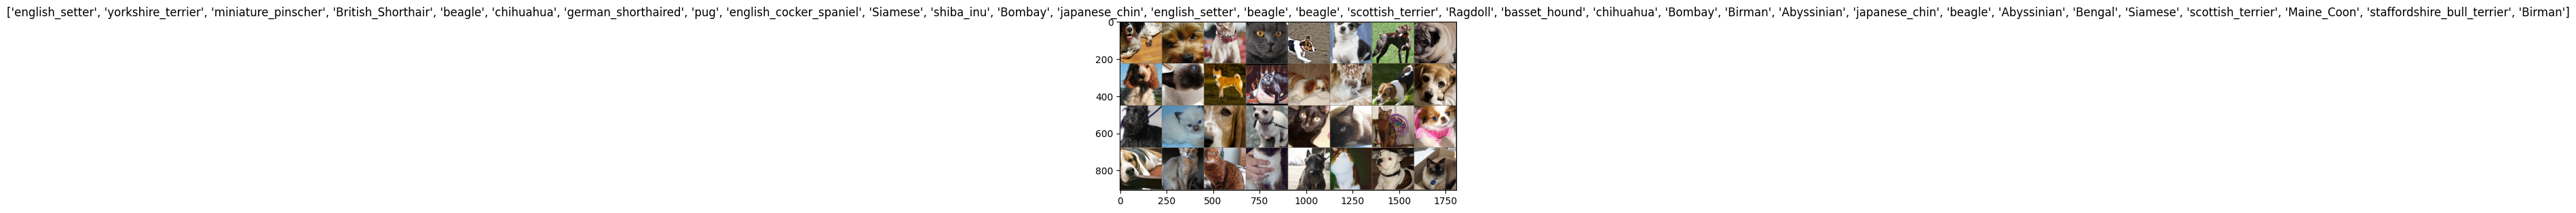

In [17]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

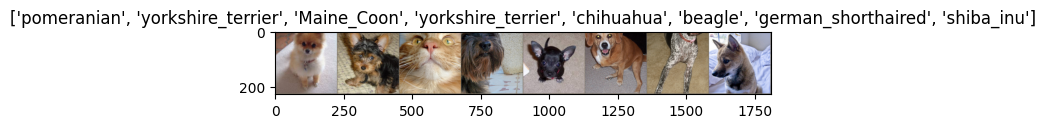

In [18]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images=8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [19]:
model_vgg = models.vgg16(weights='DEFAULT')

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [24]:
outputs_try = model_vgg(inputs_try)

In [25]:
outputs_try

tensor([[-1.5487, -0.1960,  0.9219,  ...,  0.3051,  2.7995,  1.5622],
        [-3.5516, -0.0873, -2.7925,  ..., -3.1291,  5.4573,  4.7827],
        [-2.4028, -2.5488,  0.3015,  ..., -0.4617,  0.1249,  1.1169],
        ...,
        [-1.5663,  2.9780, -1.2149,  ..., -3.0957,  6.0337,  1.0424],
        [-2.4736, -2.9629, -2.0121,  ..., -2.5727, -2.6023,  9.0639],
        [-8.5558, -7.0963, -1.4282,  ..., -6.3870,  0.2977, 14.2170]],
       grad_fn=<AddmmBackward0>)

In [26]:
outputs_try.shape

torch.Size([32, 1000])

In [28]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
for param in model_vgg.parameters():
    param.requires_grad = False
    model_vgg.classifier._modules['6'] = nn.Linear(4096,2)
    model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)    

In [31]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)


Load Model onto device(GPU,CPU,TPU)

In [32]:
model_vgg = model_vgg.to(device)

In [33]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)